# ラベル品質についてのEDA

In [18]:
from pathlib import Path

import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import polars as pl

from src.constant import LABELS
from src.preprocess import load_eeg, process_label, calc_weight, process_eeg
from src.visualization import format_time, plot_eeg

plt.style.use("tableau-colorblind10")

In [19]:
data_dir = Path("../../../input/hms-harmful-brain-activity-classification")
list(data_dir.glob("*"))
metadata = pl.read_csv(data_dir / "train.csv")
metadata = process_label(metadata)
metadata.head()

eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,total_votes,seizure_vote_per_eeg,lpd_vote_per_eeg,gpd_vote_per_eeg,lrda_vote_per_eeg,grda_vote_per_eeg,other_vote_per_eeg,label_count_per_eeg,total_votes_per_eeg,population,population_per_eeg,seizure_prob,lpd_prob,gpd_prob,lrda_prob,grda_prob,other_prob,seizure_prob_per_eeg,lpd_prob_per_eeg,gpd_prob_per_eeg,lrda_prob_per_eeg,grda_prob_per_eeg,other_prob_per_eeg,num_unique_vote_combinations_per_eeg,duration_sec,duration_min,num_labels_per_eeg,num_unique_vote_combinations_per_label,num_labels_per_duration_sec,num_unique_vote_combinations_per_duration_sec,min_eeg_label_offset_sec,max_eeg_label_offset_sec,log_num_labels_per_eeg,diversity,diversity_weight,population_weight,population_per_eeg_weight,weight,weight_per_eeg
i64,i64,f64,i64,i64,f64,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u32,f64,f64,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1628180742,0,0.0,353733,0,0.0,127492639,42516,"""Seizure""",3,0,0,0,0,0,3,3.0,0.0,0.0,0.0,0.0,0.0,9,3.0,0.107143,0.107143,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,90.0,1.5,9,0.111111,0.1,0.011111,0.0,40.0,2.197225,0.111111,1.0,0.107143,0.107143,0.107143,0.107143
1628180742,1,6.0,353733,1,6.0,3887563113,42516,"""Seizure""",3,0,0,0,0,0,3,3.0,0.0,0.0,0.0,0.0,0.0,9,3.0,0.107143,0.107143,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,90.0,1.5,9,0.111111,0.1,0.011111,0.0,40.0,2.197225,0.111111,1.0,0.107143,0.107143,0.107143,0.107143
1628180742,2,8.0,353733,2,8.0,1142670488,42516,"""Seizure""",3,0,0,0,0,0,3,3.0,0.0,0.0,0.0,0.0,0.0,9,3.0,0.107143,0.107143,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,90.0,1.5,9,0.111111,0.1,0.011111,0.0,40.0,2.197225,0.111111,1.0,0.107143,0.107143,0.107143,0.107143
1628180742,3,18.0,353733,3,18.0,2718991173,42516,"""Seizure""",3,0,0,0,0,0,3,3.0,0.0,0.0,0.0,0.0,0.0,9,3.0,0.107143,0.107143,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,90.0,1.5,9,0.111111,0.1,0.011111,0.0,40.0,2.197225,0.111111,1.0,0.107143,0.107143,0.107143,0.107143
1628180742,4,24.0,353733,4,24.0,3080632009,42516,"""Seizure""",3,0,0,0,0,0,3,3.0,0.0,0.0,0.0,0.0,0.0,9,3.0,0.107143,0.107143,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,90.0,1.5,9,0.111111,0.1,0.011111,0.0,40.0,2.197225,0.111111,1.0,0.107143,0.107143,0.107143,0.107143


## ラベルあたりのannotator数の分布

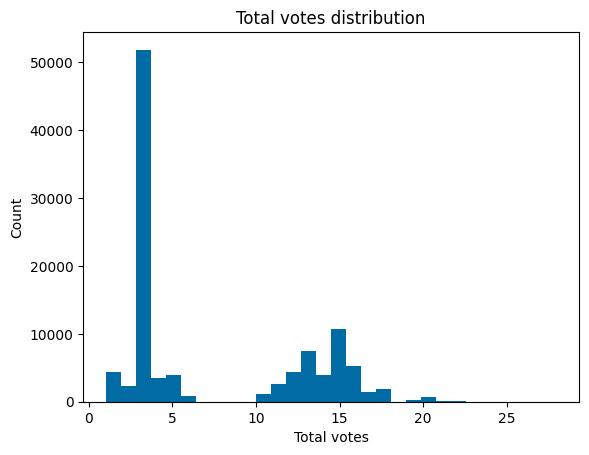

In [20]:
_, ax = plt.subplots()
metadata["total_votes"].to_pandas().plot.hist(bins=30, ax=ax)
ax.set(xlabel="Total votes", ylabel="Count", title="Total votes distribution")
plt.show()

voteが6人以下の低品質のアノテーションと、7人以上の高品質はアノテーションの2つのクラスタがある。

validationは高品質にしてtrainは低品質にするなど工夫の余地があるかもしれない。

In [21]:
min_votes = 7
dominance = (
    metadata.filter(pl.col("total_votes") >= min_votes).shape[0] / metadata.shape[0]
)
print(f"{min_votes}人以上voteがあるlabelの割合: {dominance:.3f}")

7人以上voteがあるlabelの割合: 0.374


## ユニークなvoteの組み合わせの数

In [22]:
def plot_empirical_density(df, column, group_col=None):
    if group_col is not None:
        df = df.group_by(group_col).agg(pl.col(column).first().alias(column))

    _, ax = plt.subplots()
    df = (
        df.group_by(pl.col(column))
        .agg(pl.count().alias("count"))
        .with_columns(
            pl.col("count").truediv(df.shape[0]).alias("ratio"),
        )
        .sort(column)
        .with_columns(
            pl.col("ratio").cum_sum().alias("ECDF"),
        )
        .with_columns(
            pl.lit(1.0).sub(pl.col("ECDF")).alias("RECDF"),
        )
    )

    ax.step(df[column], df["ratio"], label="ratio", color="C0", lw=0.8)
    ax.step(
        [0] + df[column].to_list(),
        [0] + df["ECDF"].to_list(),
        label="Empirical CDF",
        linestyle="dashed",
        color="C1",
        lw=0.8,
    )
    ax.plot(
        [0, df[column].max()],
        [0, 1],
        label="ECDF of uniform dist",
        color="red",
        linestyle="dotted",
        lw=0.8,
    )
    ax.legend()
    ax.set(
        xlabel=column,
        ylabel="Density",
        title=f"Distribution of {column}",
    )
    plt.show()

    return df.select(column, "ratio", "ECDF", "RECDF")

/tmp/ipykernel_878563/1865086927.py:8: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias("count"))


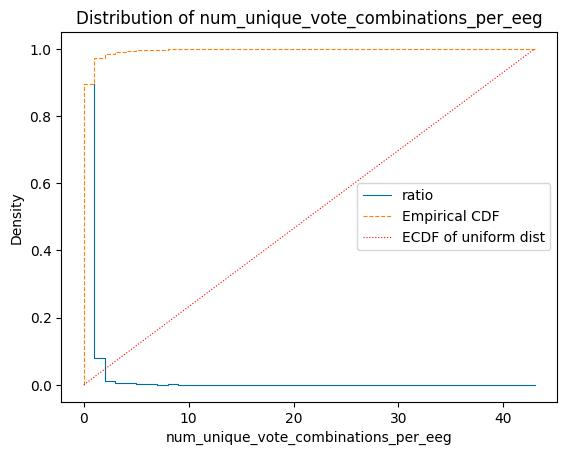

num_unique_vote_combinations_per_eeg,ratio,ECDF,RECDF
u32,f64,f64,f64
1,0.894259,0.894259,0.105741
2,0.078881,0.973141,0.026859
3,0.011703,0.984844,0.015156
4,0.005735,0.990579,0.009421
5,0.003862,0.994441,0.005559


In [23]:
df = plot_empirical_density(metadata, "num_unique_vote_combinations_per_eeg", group_col="eeg_id")
df.head()

ユニークなvoteの組み合わせが1種類のみのEEGが全体の89.4%を占める。また、voteの組み合わせが3つ以上のEEGは全体の2.7%にとどまる。

/tmp/ipykernel_878563/1865086927.py:8: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias("count"))


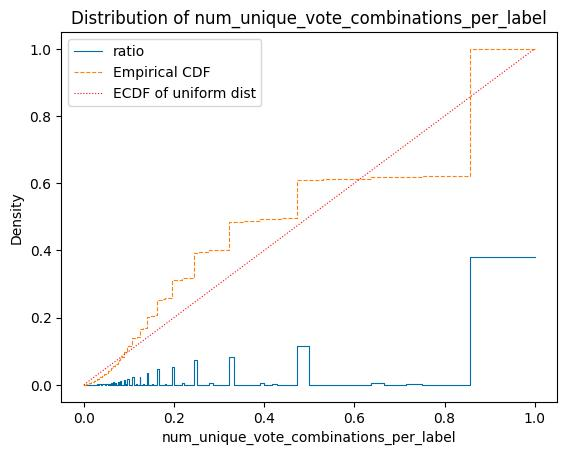

num_unique_vote_combinations_per_label,ratio,ECDF,RECDF
f64,f64,f64,f64
0.001346,0.000059,0.000059,0.999941
0.001506,0.000059,0.000117,0.999883
0.001779,0.000059,0.000176,0.999824
0.001883,0.000059,0.000234,0.999766
0.002309,0.000059,0.000293,0.999707


In [24]:
df = plot_empirical_density(metadata, "num_unique_vote_combinations_per_label", group_col="eeg_id")
df.head()

## EEGあたりのラベル数

/tmp/ipykernel_878563/1865086927.py:8: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias("count"))


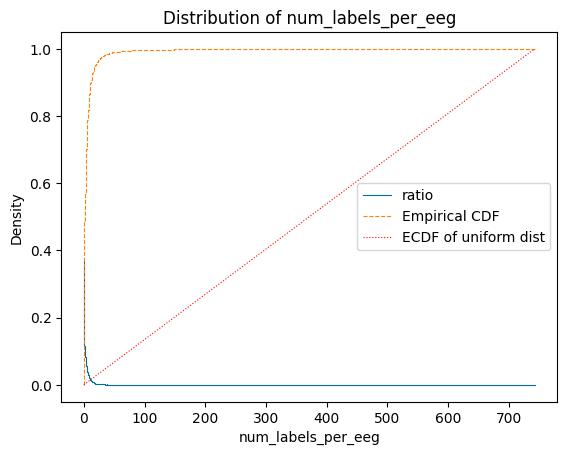

num_labels_per_eeg,ratio,ECDF,RECDF
u32,f64,f64,f64
1,0.370063,0.370063,0.629937
2,0.115454,0.485517,0.514483
3,0.08368,0.569197,0.430803
4,0.077126,0.646322,0.353678
5,0.055123,0.701445,0.298555
6,0.048803,0.750249,0.249751
7,0.039031,0.78928,0.21072
8,0.028439,0.817719,0.182281
9,0.026508,0.844227,0.155773


In [25]:
df = plot_empirical_density(metadata, "num_labels_per_eeg", group_col="eeg_id")
df.head(10)

ラベルが1つしか与えられていないEEGが全体の37.0%を占める。

## EEGの系列長あたりのラベル数

/tmp/ipykernel_878563/1865086927.py:8: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias("count"))


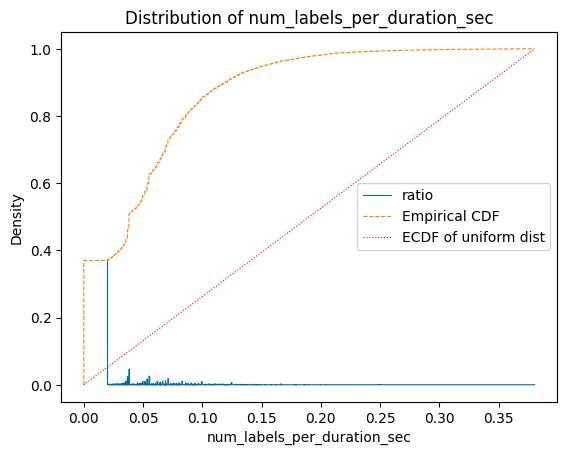

In [26]:
df = plot_empirical_density(metadata, "num_labels_per_duration_sec", group_col="eeg_id")

## weightの設計

vote数が少ないラベルのパラメータ更新への寄与が少なくなるようなweightを設計する。

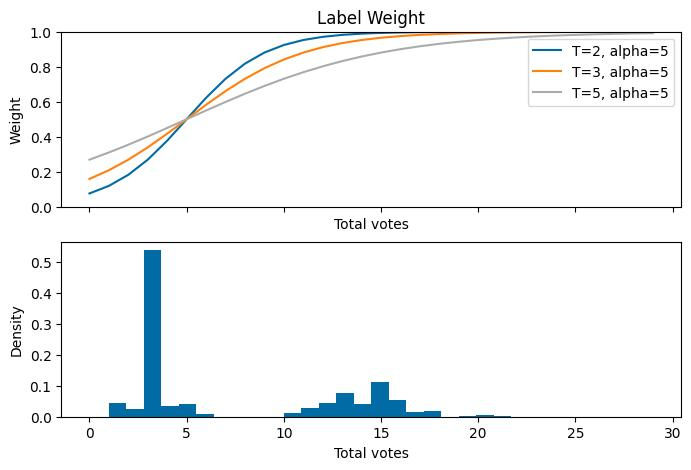

In [27]:
_, (ax, ax2) = plt.subplots(2, 1, figsize=(8, 5), sharex=True)
ax.set(xlabel="Total votes", ylabel="Weight", title="Label Weight")
ax.set_ylim(0, 1)

alpha = 5
for T in [2, 3, 5]:
    xs = np.arange(30)
    ys = calc_weight(xs, T, alpha)
    ax.plot(xs, ys, label=f"T={T}, alpha={alpha}")

ax.legend()
df = metadata["total_votes"].to_pandas()
ax2.hist(df, bins=30, density=True, color="C0")
ax2.set(xlabel="Total votes", ylabel="Density")

plt.show()

## weightの分布

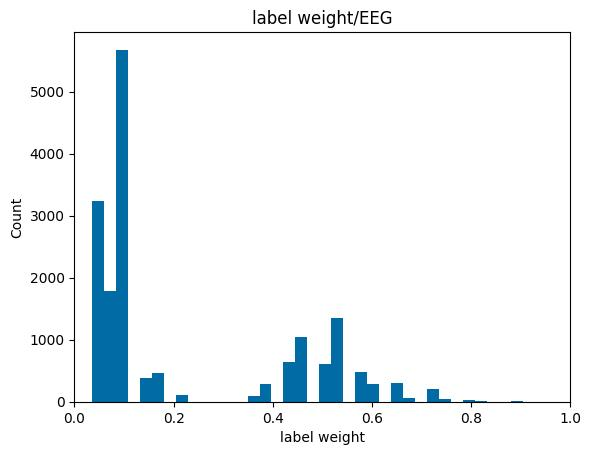

In [28]:
df = metadata.group_by("eeg_id").agg(pl.col("weight").first())["weight"]

_, ax = plt.subplots()
ax.hist(df, bins=40)
ax.set(
    xlabel="label weight",
    ylabel="Count",
    # yscale="log",
    xlim=(0, 1),
    title="label weight/EEG",
)
plt.show()

## fold分割時のラベル分布の偏り

eeg_id単位でサンプリングした場合
Fold 0 - train: 13671, valid: 3418 (22104 labels)
Fold 1 - train: 13671, valid: 3418 (20426 labels)
Fold 2 - train: 13671, valid: 3418 (21039 labels)
Fold 3 - train: 13671, valid: 3418 (22305 labels)
Fold 4 - train: 13672, valid: 3417 (20926 labels)


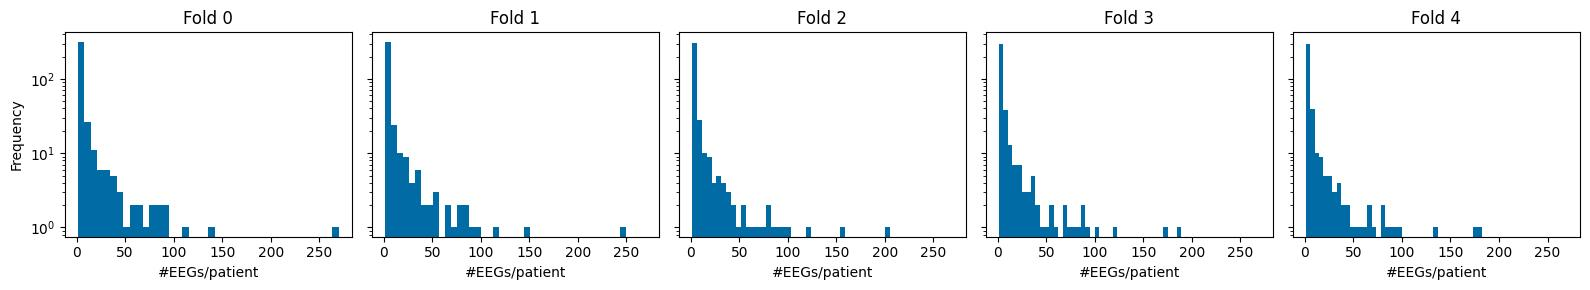


label_id単位でサンプリングした場合
Fold 0 - train: 85440, valid: 21360 (3290 eegs)
Fold 1 - train: 85440, valid: 21360 (3470 eegs)
Fold 2 - train: 85440, valid: 21360 (3495 eegs)
Fold 3 - train: 85440, valid: 21360 (3148 eegs)
Fold 4 - train: 85440, valid: 21360 (3686 eegs)


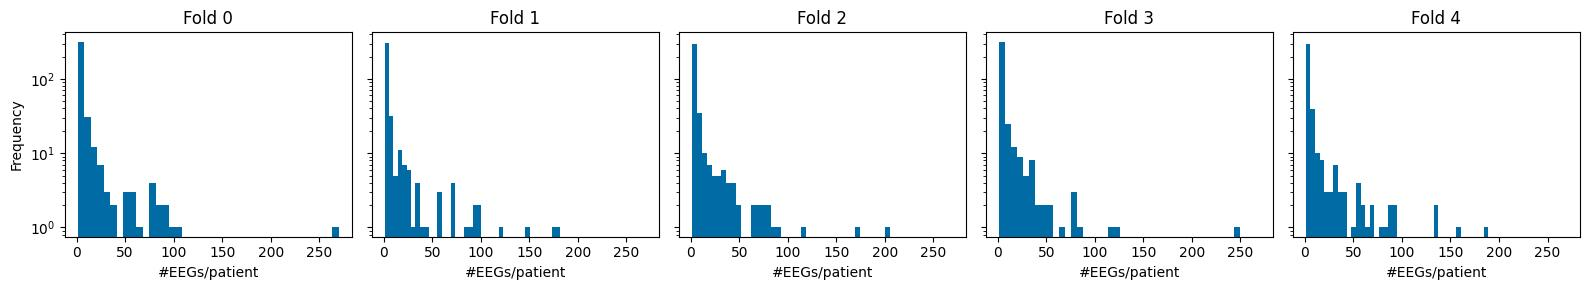

In [29]:
from sklearn.model_selection import GroupKFold

group_kfold = GroupKFold(n_splits=5)
labels = metadata.select("eeg_id", "label_id", "patient_id")

print("eeg_id単位でサンプリングした場合")
keys = metadata.select("eeg_id", "patient_id").unique().to_pandas()

_, axes = plt.subplots(1, 5, figsize=(16, 3), sharex=True, sharey=True)
for fold, (train_idxs, valid_idxs) in enumerate(
    group_kfold.split(keys[["eeg_id"]], keys["eeg_id"], keys["patient_id"])
):
    df_valid = pl.from_pandas(keys.iloc[valid_idxs])
    valid_eeg_ids = set(df_valid["eeg_id"].to_list())
    df_valid_labels = labels.filter(pl.col("eeg_id").is_in(valid_eeg_ids))

    df_valid.group_by("patient_id").agg(
        pl.col("eeg_id").count().alias("num_eegs_per_patient")
    ).to_pandas().set_index("patient_id").plot.hist(bins=40, ax=axes[fold])
    axes[fold].set(
        ylabel="Frequency", title=f"Fold {fold}", xlabel="#EEGs/patient", yscale="log"
    )
    axes[fold].legend().remove()
    print(
        f"Fold {fold} - train: {len(train_idxs)}, valid: {len(valid_idxs)} ({len(df_valid_labels)} labels)"
    )

plt.tight_layout()
plt.show()
print("")

print("label_id単位でサンプリングした場合")
keys = metadata.select("eeg_id", "label_id", "patient_id").to_pandas()

_, axes = plt.subplots(1, 5, figsize=(16, 3), sharex=True, sharey=True)
for fold, (train_idxs, valid_idxs) in enumerate(
    group_kfold.split(keys[["label_id"]], keys["label_id"], keys["patient_id"])
):
    df_valid = pl.from_pandas(keys.iloc[valid_idxs])
    df_valid = df_valid.select("eeg_id", "patient_id").unique()
    unique_eegs_in_val = len(df_valid)

    df_valid.group_by("patient_id").agg(
        pl.col("eeg_id").count().alias("num_eegs_per_patient")
    ).to_pandas().set_index("patient_id").plot.hist(bins=40, ax=axes[fold])
    axes[fold].set(
        ylabel="Frequency", title=f"Fold {fold}", xlabel="#EEGs/patient", yscale="log"
    )
    axes[fold].legend().remove()
    print(
        f"Fold {fold} - train: {len(train_idxs)}, valid: {len(valid_idxs)} ({unique_eegs_in_val} eegs)"
    )
plt.tight_layout()
plt.show()

## voteの多様性が大きいサンプルの可視化

In [37]:
def votes2tag(votes: dict):
    vote_tuples = sorted(votes.items(), key=lambda x: x[1], reverse=True)
    return ", ".join([f"{vote} {label}" for label, vote in vote_tuples if vote > 0])


def plot_label(
    label,
    label_start_sec,
    label_end_sec,
    center_sec,
    label_idx: int,
    duration: float,
    ax,
    fig,
    cmap="coolwarm",
    display_all_series=True,
):
    this_center_sec = center_sec[label_idx]
    num_labels = len(LABELS)

    shift = 1 / num_labels
    ax.set_yticks(
        ticks=np.linspace(shift / 2, 1 - shift / 2, num_labels), labels=LABELS
    )
    cmap = plt.get_cmap(cmap)
    norm = mcolors.Normalize(vmin=0, vmax=1)

    for idx, (start, end, gt_prob) in enumerate(
        zip(label_start_sec, label_end_sec, label)
    ):
        if (not display_all_series) and (
            (end < this_center_sec - duration / 2)
            or (this_center_sec + duration / 2 < start)
        ):
            continue

        alpha = 0.8 if idx == label_idx else 0.2
        for i, p in enumerate(gt_prob):
            color = cmap(norm(p))
            ax.axvspan(
                start,
                end,
                i / num_labels,
                (i + 1) / num_labels,
                color=color,
                alpha=alpha,
                lw=0.8,
            )

    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # カラーバーを追加
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label("Probability")
    formatter = ticker.FuncFormatter(format_time)
    ax.xaxis.set_major_formatter(formatter)


def plot_weight(time_sec: np.ndarray, weight: np.ndarray, ax):
    ax.plot(time_sec, weight, label="weight", marker="o", color="black")
    ax.legend()
    ax.set_ylim(0, 1)


def display_labels_with_eeg(
    eeg_id: int,
    display_all_series: bool = True,
    time_zoom: float = 1,
    eeg_duration_sec: float = 50,
    label_duration_sec: float = 10,
    cmap_name="coolwarm",
):
    """
    ラベルを時間軸上にプロットする。
    ラベルは50secのフレームの中心から前後5secの範囲に存在する。
    """

    label_df = metadata.filter(pl.col("eeg_id").eq(eeg_id))
    # label, quality, total_vote = process_label(label_df)
    label = label_df.select(f"{label}_prob" for label in LABELS).to_numpy()
    weight = label_df.select("weight").to_numpy()
    eeg_label_offset_seconds = label_df.get_column(
        "eeg_label_offset_seconds"
    ).to_numpy()
    center_sec = eeg_label_offset_seconds + eeg_duration_sec / 2
    label_start_sec = center_sec - label_duration_sec / 2
    label_end_sec = center_sec + label_duration_sec / 2
    patient_id = label_df.select("patient_id").to_numpy()[0][0]

    num_labels = len(label)
    label_idx = np.random.randint(num_labels)

    this_votes = (
        label_df[label_idx].select(f"{label}_vote" for label in LABELS).to_numpy()
    )
    this_votes = {
        label: vote for label, vote in zip(LABELS, this_votes.ravel()) if vote > 0
    }
    tag = votes2tag(this_votes)

    fig, (ax2, ax, ax3) = plt.subplots(
        3,
        1,
        figsize=(12, 7),
        sharex=True,
        constrained_layout=True,
        gridspec_kw={"height_ratios": [7, 2, 1]},
    )
    plot_label(
        label,
        label_start_sec,
        label_end_sec,
        center_sec,
        label_idx,
        eeg_duration_sec,
        ax,
        fig,
        cmap=cmap_name,
        display_all_series=display_all_series,
    )

    eeg_df = load_eeg(eeg_id, data_dir, phase="train")
    eeg, pad_mask = process_eeg(eeg_df, cutoff_freqs=(0.5, 50))
    eeg /= 1000
    plot_eeg(
        eeg,
        offset_sec=eeg_label_offset_seconds[label_idx],
        ax=ax2,
        time_zoom=time_zoom,
        display_all_series=display_all_series,
    )
    plot_weight(center_sec, weight, ax=ax3)

    plt.suptitle(f"{tag} (EEG ID: {eeg_id}, patient ID: {patient_id})", fontsize=16)

In [38]:
metadata_eeg = metadata.group_by("eeg_id").agg(
    pl.col("num_unique_vote_combinations_per_eeg").first()
)
metadata_eeg.filter(pl.col("num_unique_vote_combinations_per_eeg").gt(1)).shape[0] / metadata_eeg.shape[0]

0.10574053484697758

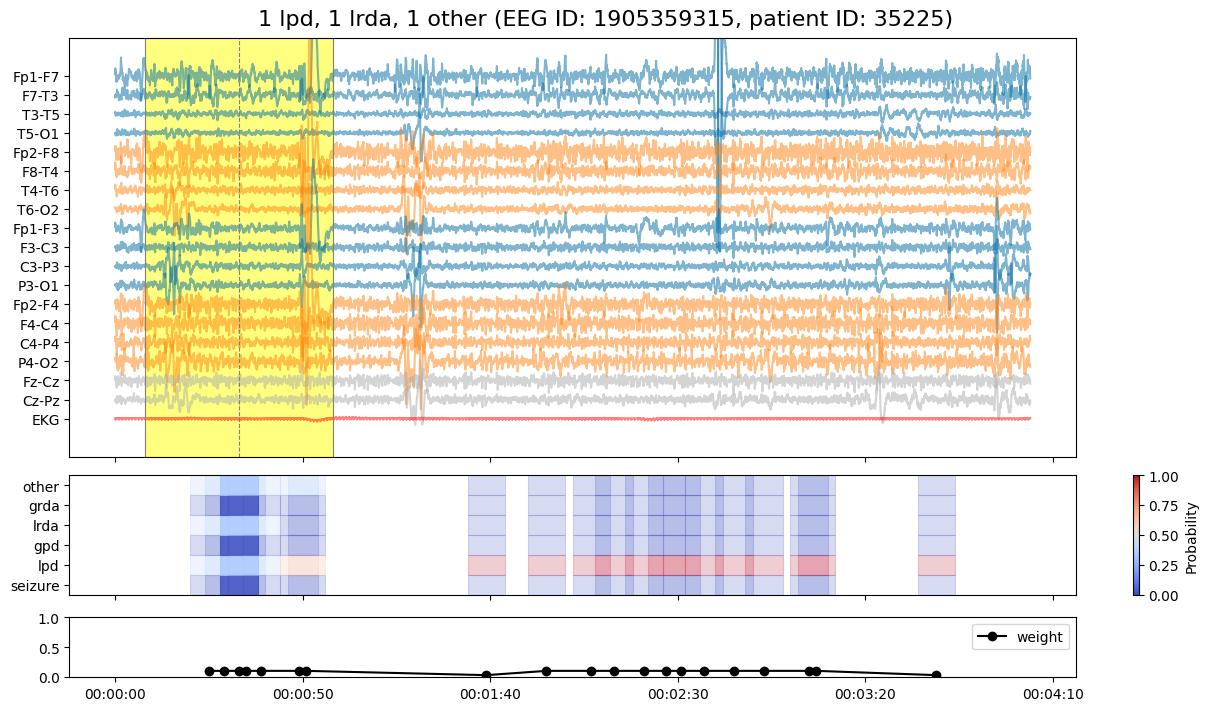

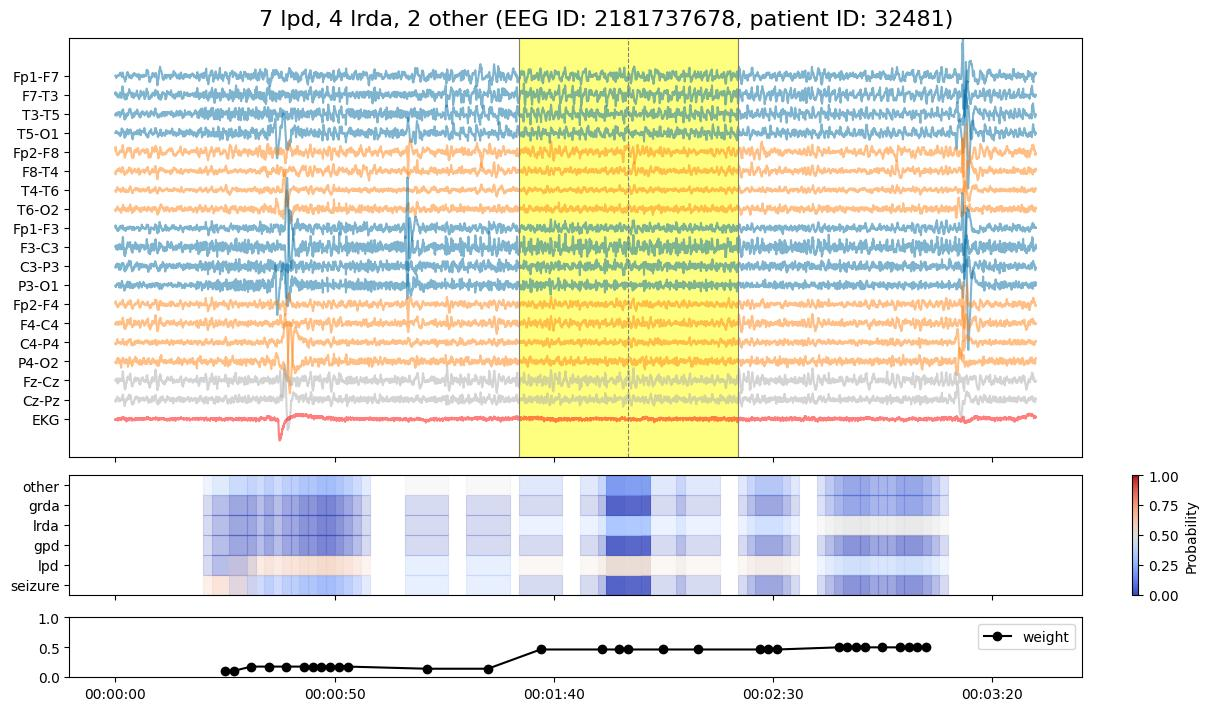

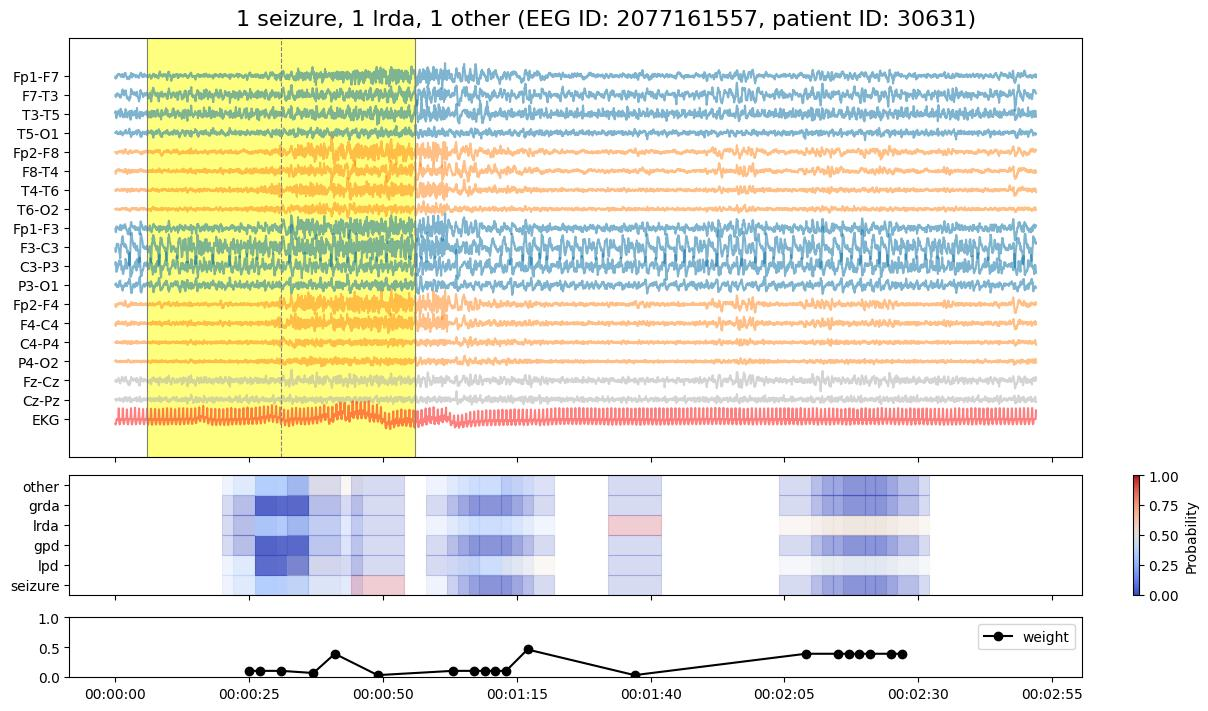

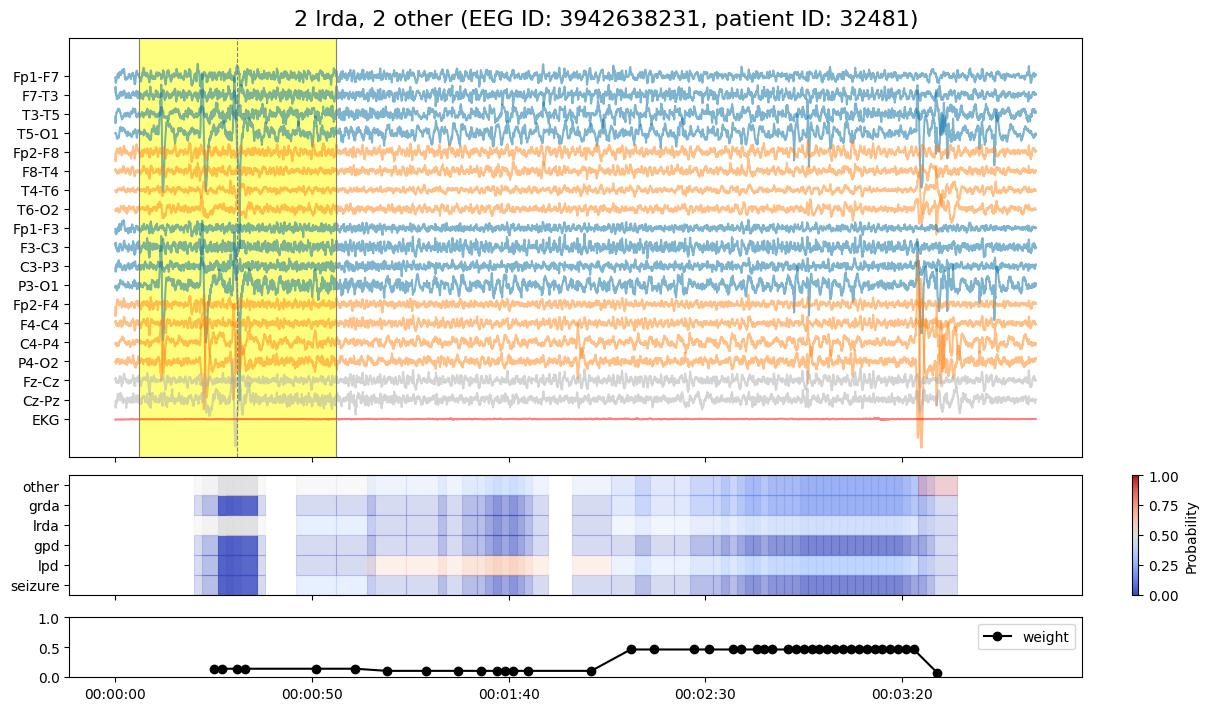

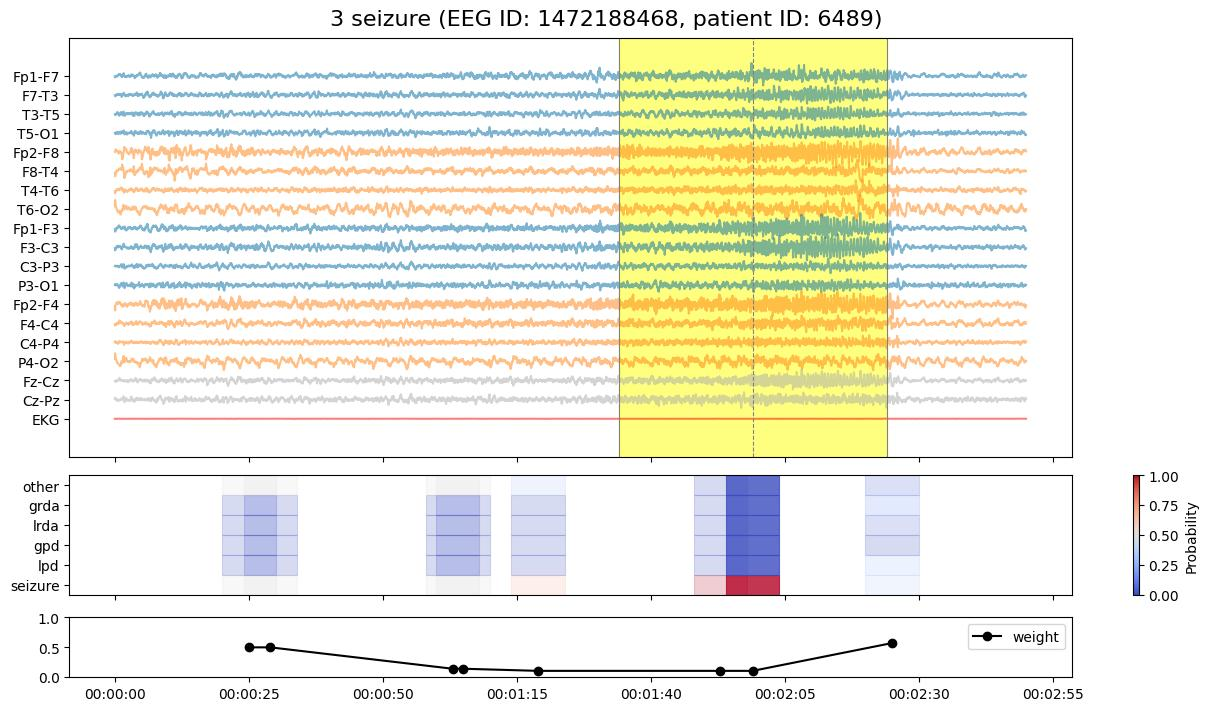

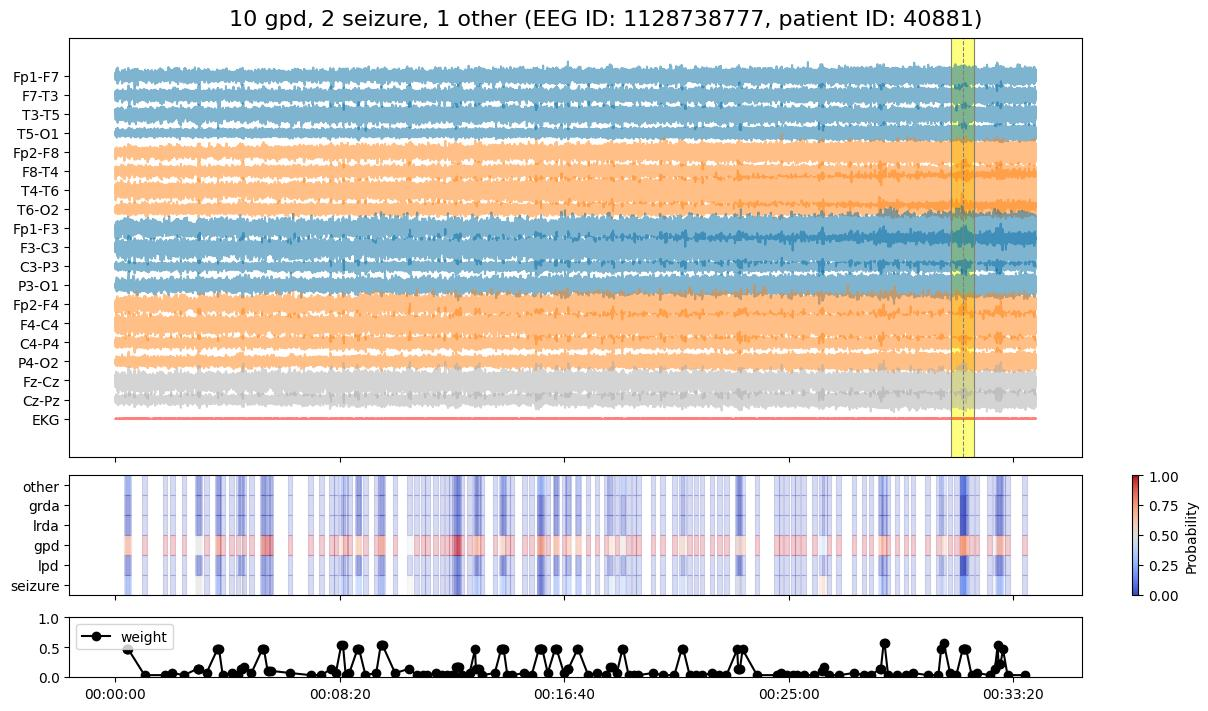

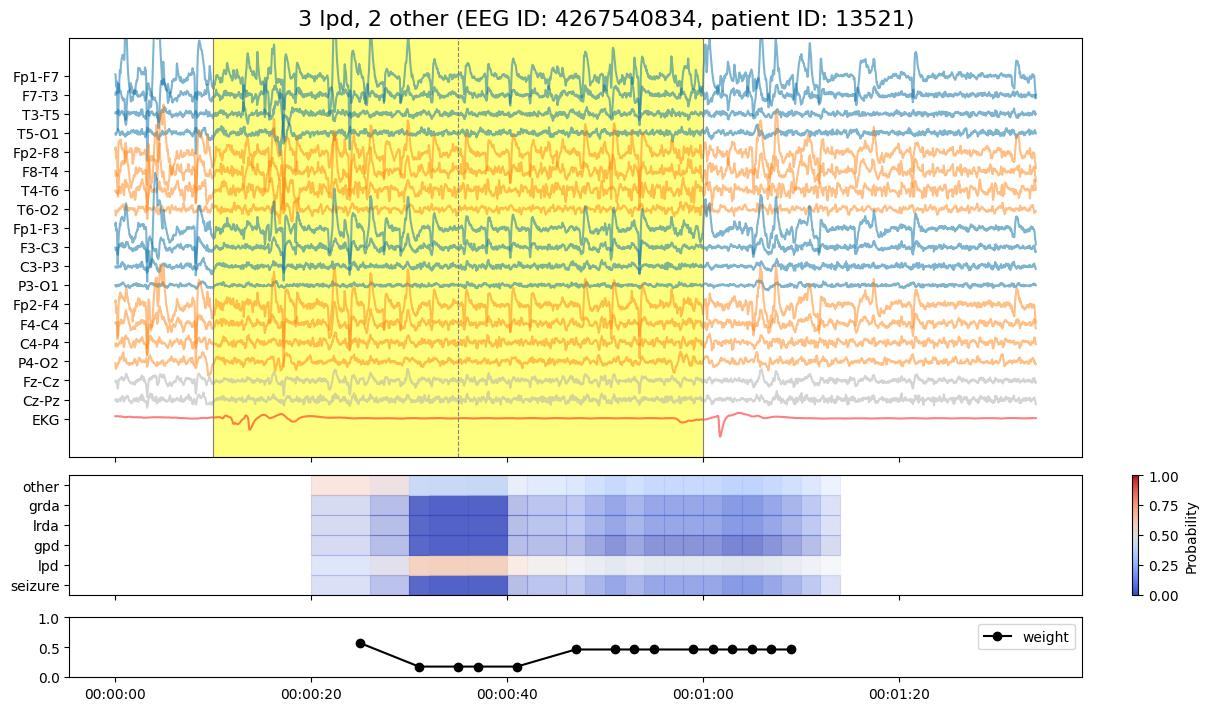

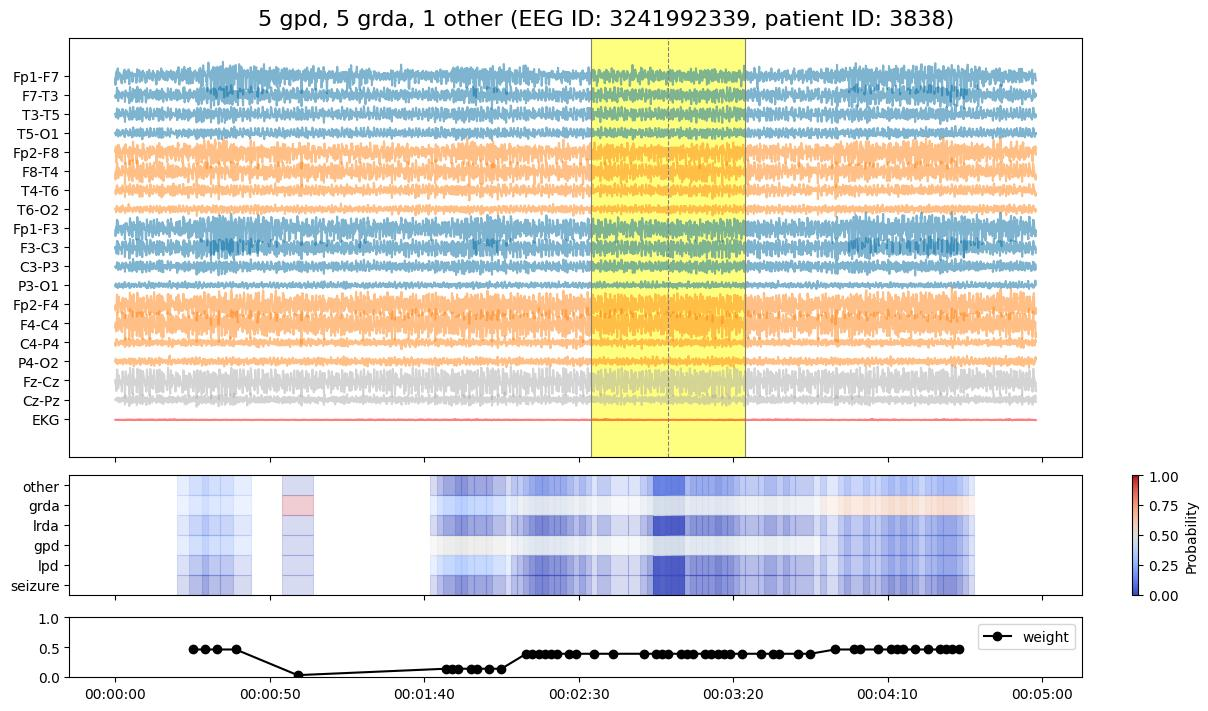

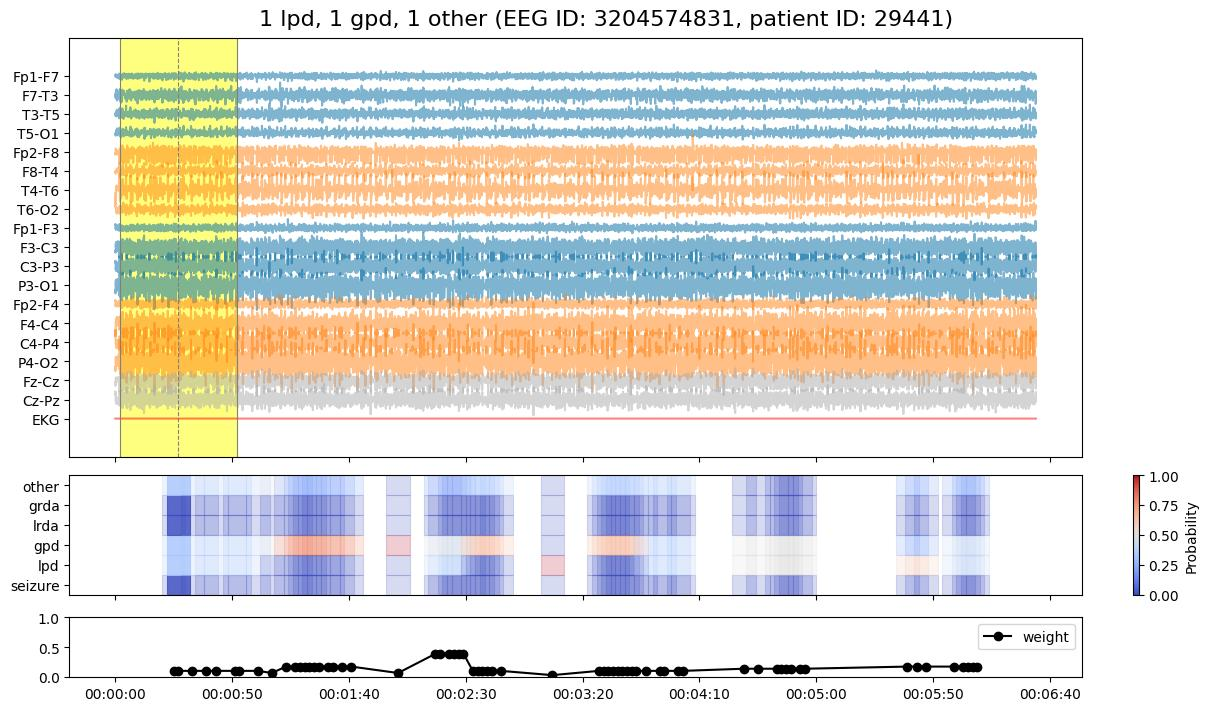

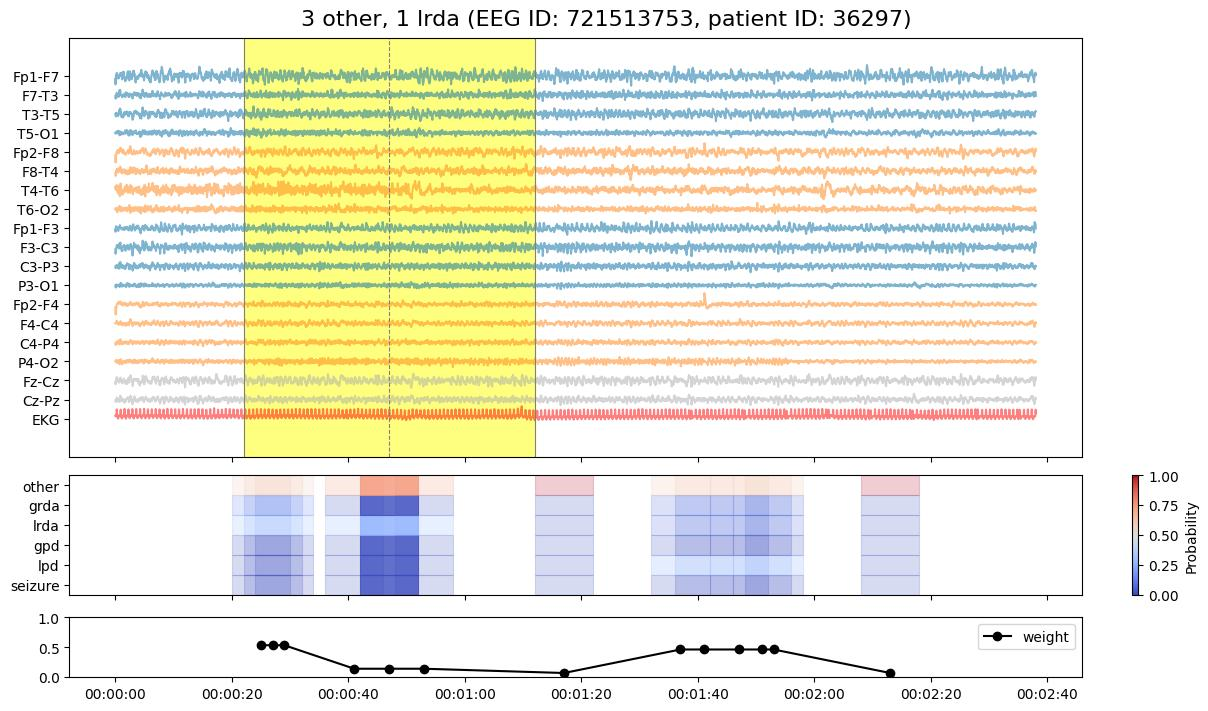

In [39]:
sample_eeg_ids = (
    metadata.filter(pl.col("num_unique_vote_combinations_per_eeg") >= 3)
    .get_column("eeg_id")
    .sample(10)
)

for eeg_id in sample_eeg_ids:
    display_labels_with_eeg(eeg_id)
    plt.show()

## 調査から得た知見

- annotator数が7人未満の低品質のラベル(62.6%)と、それ以外の高品質なラベル(37.4%)からなる
- EEGあたりのユニークなvoteの数が1のものが76.3%と大部分を占める（つまり、全体の3/4のラベルは時間方向のラベルとして意味をなさない）

## 出てきた課題/アイデア

- trainの大部分はqualityが低く、時系列方向の解像度も低い（or ない） -> 一種のweak label
    - おそらくtestではちゃんと時系列として意味のあるラベルになっているのだと想定している。
    - trainの大部分のサンプルは時系列方向のラベルはほぼ意味をなしていないので、これを暗黙的に与えるような教師なし学習の手法が有効かもしれない。
- validationの仕方の工夫
    - qualityとdiversityがともに大きいサンプルをvalidationにすると良いかもしれない
- augmentationのアイデア
    - 意図的に紛らわしいサンプルを作るという意味で、mixup/cutmixが有効かもしれない
- qualityの特徴の利用
    - 低品質のラベルを無視するか重みを弱くすることができる
- sampling
    - 時系列方向のアノテーションが意味をなさないサンプルが多いので、eeg_id単位でサンプリングしても学習に影響しないと想定。

## さらに調査できそうなところ

- ラベルが付加されている時系列の時点と、それ以外の時点にどのような差があるのか？